In [24]:
import os
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from factor_analyzer import FactorAnalyzer
from models import Autoencoder
from sklearn.decomposition import NMF
from sklearn.linear_model import Lasso, LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import cx_Oracle
from utils import translate_text
from sklearn.model_selection import KFold

# Main 

## Preparing the data

In [25]:
code_dir = Path(os.getcwd())
data_path = code_dir.parent / "data"
assert os.path.exists(
    data_path
), "Data directory not found. Make sure you're running this code from the root directory of the project."

with open(data_path / "cbcl_data_remove_unrelated.csv", "r", encoding="utf-8") as f:
    qns = pd.read_csv(f)

X = qns.iloc[:, 1:].values

# Standardize the data
# scaler = StandardScaler()
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

# Split into training and validation sets
X_train_raw, X_temp = train_test_split(X, test_size=0.4)
X_val_raw, X_test_raw = train_test_split(X_temp, test_size=0.5)


X_train = scaler.fit_transform(X_train_raw)
X_val = scaler.transform(X_val_raw)
X_test = scaler.transform(X_test_raw)

## Train and save the model

Early stopping at epoch 68


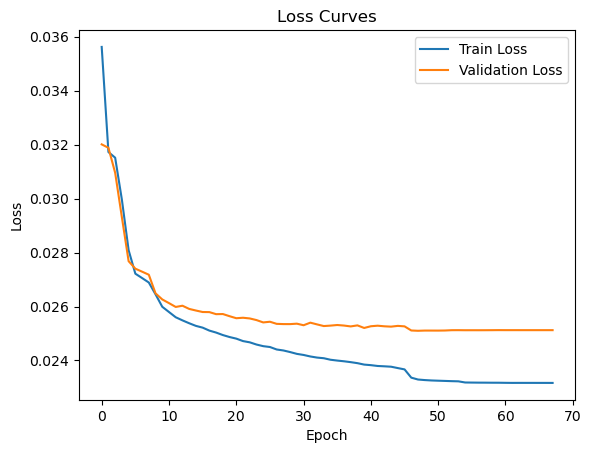

In [26]:
autoencoder = Autoencoder(X_train, X_val, encoding_dim=5, 
                          layer1_neurons=103, layer2_neurons=45, layer3_neurons=54)
autoencoder.train()
(
    latent_factors,
    reconstruction_errors_test,
    explained_variance_ratios,
    explained_variance_ratio_total,
) = autoencoder.evaluate_on_data(X_scaled)

In [ ]:
#save the model
autoencoder.export_to_onnx(X_train, onnx_path = "../output/autoencoder_real_input.onnx")  # export model

Model exported to ../output/autoencoder_real_input.onnx
Serving '../output/autoencoder_real_input.onnx' at http://localhost:8080


In [4]:
latent_factors = latent_factors  # convert to NumPy
X_scaled = np.array(X_scaled)  # convert to NumPy

# calculate loadings
loadings = []
for i in range(X_scaled.shape[1]):  # transversal all features
    reg = LinearRegression().fit(latent_factors, X_scaled[:, i])  # regression
    loadings.append(reg.coef_)  # store the coefficients

loading_matrix = np.array(
    loadings
).T  #  transpose to (latent factors, original features)

print("Loading matrix shape:", loading_matrix.shape)

Loading matrix shape: (5, 113)


### 10 Fold

Fold 1
Early stopping at epoch 54


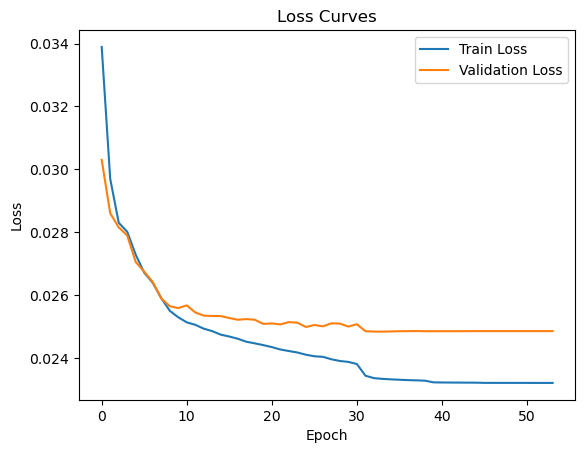

Explained variance ratio: 0.40251870011184054
Fold 2
Early stopping at epoch 54


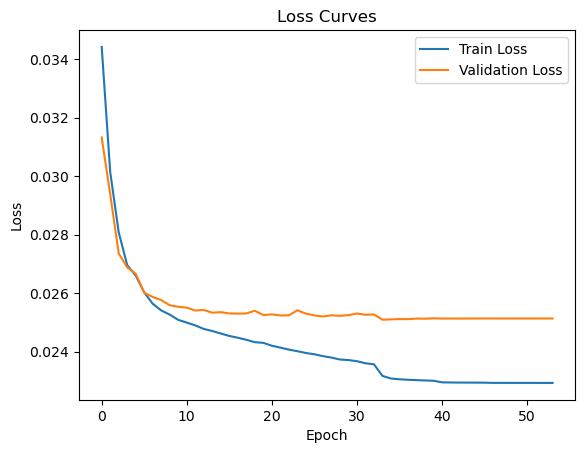

Explained variance ratio: 0.4103252271422524
Fold 3
Early stopping at epoch 49


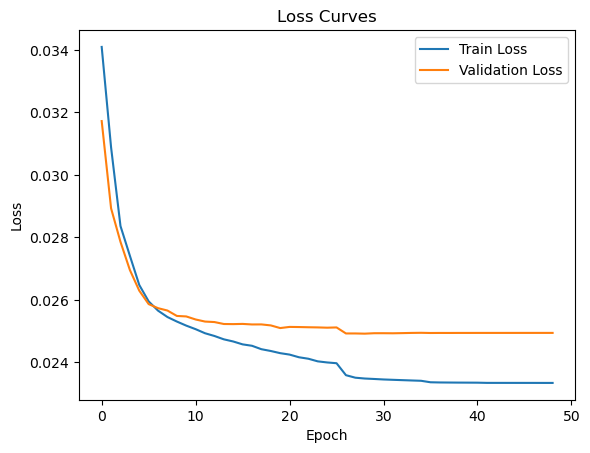

Explained variance ratio: 0.4036263806196724
Fold 4
Early stopping at epoch 61


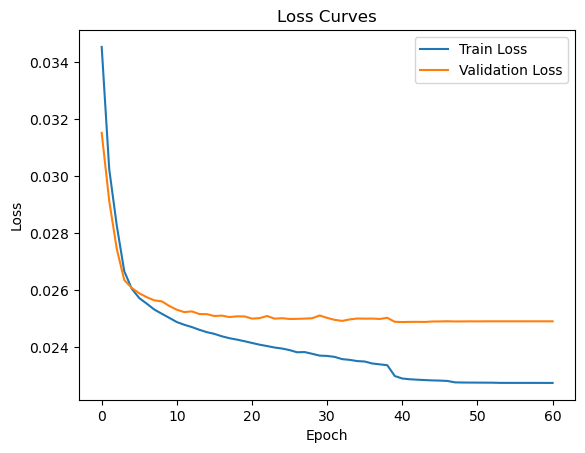

Explained variance ratio: 0.4102583102574868
Fold 5
Early stopping at epoch 60


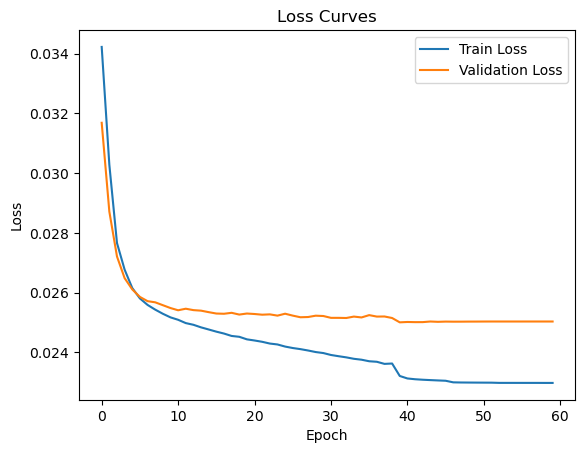

Explained variance ratio: 0.4061343267664161
Fold 6
Early stopping at epoch 53


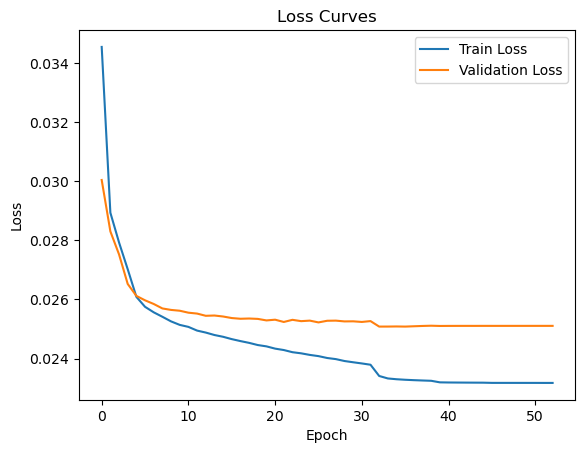

Explained variance ratio: 0.4001809744685646
Fold 7
Early stopping at epoch 53


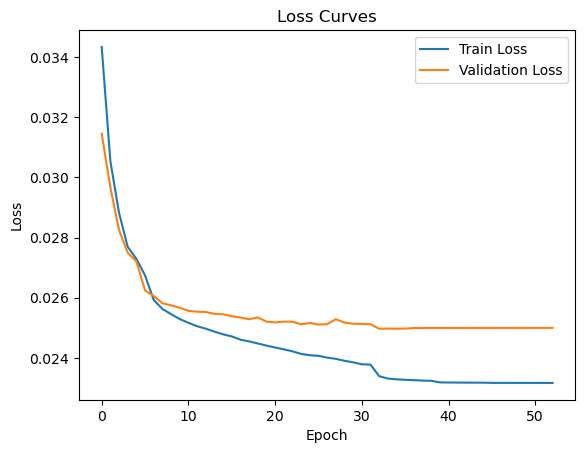

Explained variance ratio: 0.40255885566546207
Fold 8
Early stopping at epoch 60


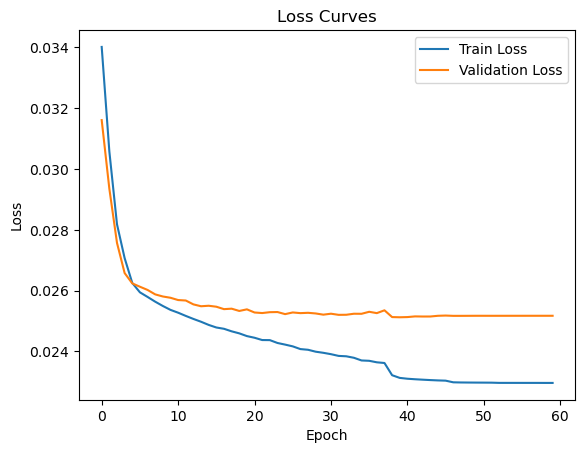

Explained variance ratio: 0.40671678564750785
Fold 9
Early stopping at epoch 58


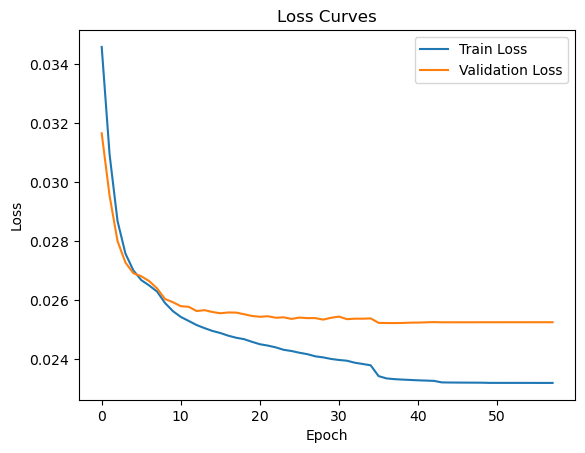

Explained variance ratio: 0.40137753404781523
Fold 10
Early stopping at epoch 57


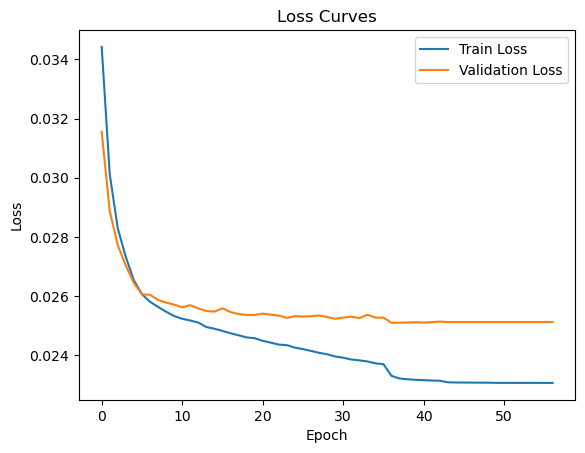

Explained variance ratio: 0.405040094708683


In [16]:
kf = KFold(n_splits=10, shuffle=True)
fold = 1
variances_explained = []
for train_index, val_index in kf.split(X_train):
    print(f"Fold {fold}")
    X_train_fold, X_val_fold = X_train[train_index], X_train[val_index]
    autoencoder = Autoencoder(X_train, X_val, encoding_dim=5, 
                            layer1_neurons=103, layer2_neurons=45, layer3_neurons=54)
    autoencoder.train()
    (
        latent_factors,
        reconstruction_errors_test,
        explained_variance_ratios,
        explained_variance_ratio_test,
    ) = autoencoder.evaluate_on_data(X_scaled)
    fold += 1
    variances_explained.append(autoencoder.explained_variance_ratio_total(X_test))
    print(f"Explained variance ratio: {autoencoder.explained_variance_ratio_total(X_test)}")
average_variances_explained = np.mean(variances_explained)

## Draw the reconstuction error of the autoencoder model

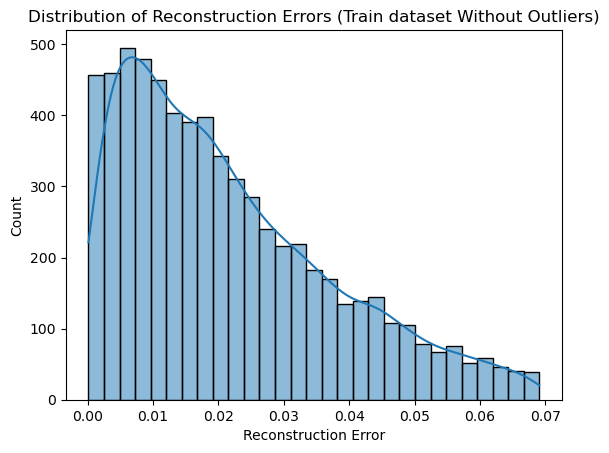

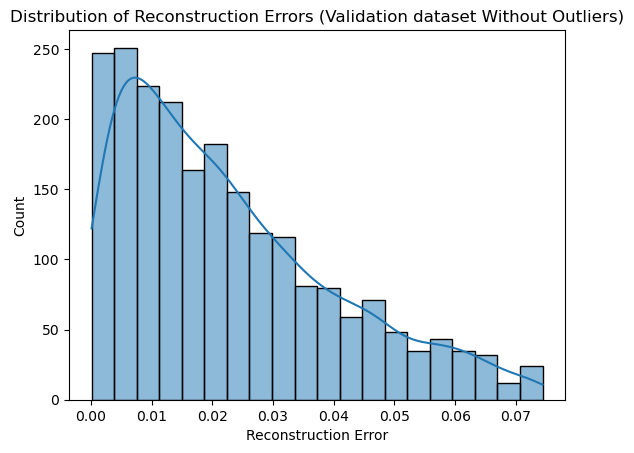

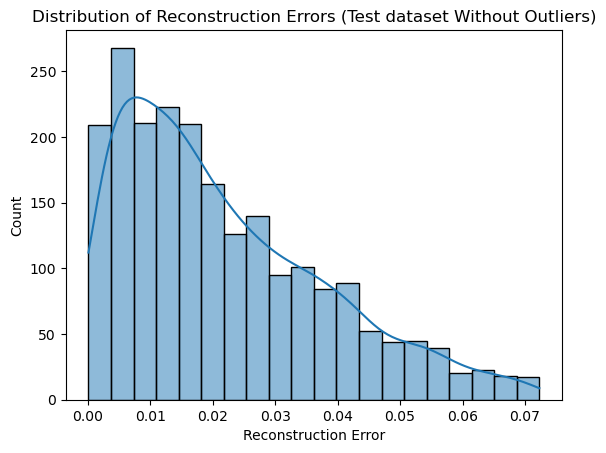

In [7]:
# Define the datasets
datasets = {"Train": X_train, "Validation": X_val, "Test": X_test}

# Plot the reconstruction errors
autoencoder.plot_reconstruction_errors(datasets)

## Explore the possible dimensions of the hidden layers

dim: 4
Early stopping at epoch 124


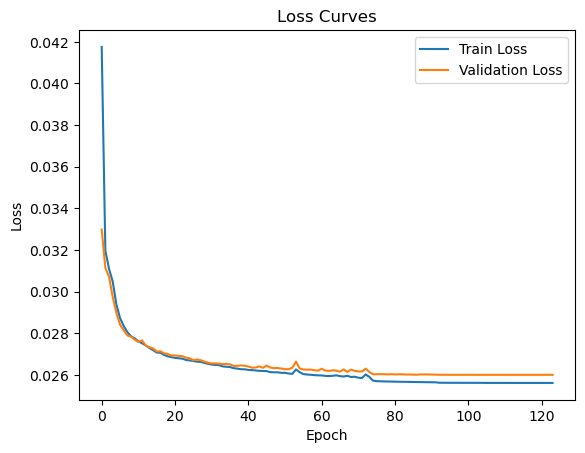

C:\Users\Makka Papa\AppData\Local\Temp\ipykernel_14372\3577538529.py:42: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  dim_df = pd.concat([dim_df, temp_df], ignore_index=True)


dim: 5
Early stopping at epoch 77


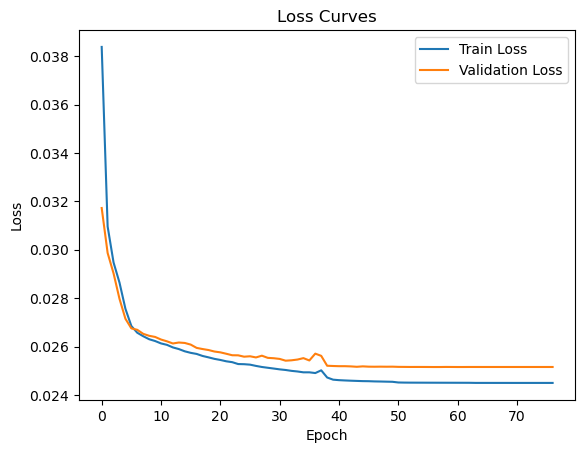

  dim  Factor_1  Factor_2  Factor_3  Factor_4  Factor_5 Factor_6 Factor_7  \
0   4  0.357056  0.134247  0.269949  0.190954       NaN     None     None   
1   5  0.060660  0.067453  0.042017  0.061604  0.025882     None     None   

  Factor_8 Factor_9 Factor_10  Total variance ratio  
0     None     None      None              0.364685  
1     None     None      None              0.390815  


C:\Users\Makka Papa\AppData\Local\Temp\ipykernel_14372\3577538529.py:42: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  dim_df = pd.concat([dim_df, temp_df], ignore_index=True)


In [8]:
# Initialize the DataFrame to store the results
dim_df = pd.DataFrame(
    columns=["dim"] + [f"Factor_{i+1}" for i in range(10)] + ["Total variance ratio"]
)

for latent_dim in range(4, 6):
    print("dim:", latent_dim)

    # Initialize and train the autoencoder
    autoencoder = Autoencoder(X_train, X_val, encoding_dim=latent_dim)
    autoencoder.train()

    # Evaluate the autoencoder on the scaled data
    (
        latent_factors,
        reconstruction_errors,
        explained_variance_ratios,
        explained_variance_ratio_total,
    ) = autoencoder.evaluate_on_data(X_scaled)

    # Create a temporary DataFrame to store the results for the current latent dimension
    temp_df = pd.DataFrame(
        {
            "dim": [latent_dim],  # Current dimension
            **{
                f"Factor_{i+1}": ratio
                for i, ratio in enumerate(explained_variance_ratios)
            },
            "Total variance ratio": [explained_variance_ratio_total],
        }
    )

    # Fill missing factor columns with NaN to maintain consistent column names
    for col in dim_df.columns:
        if col not in temp_df.columns:
            temp_df[col] = None  # Fill with NaN

    # Sort columns to match the order in dim_df
    temp_df = temp_df[dim_df.columns]

    # Concatenate the temporary DataFrame with the main DataFrame
    dim_df = pd.concat([dim_df, temp_df], ignore_index=True)

print(dim_df)

## Other approaches to extract factors: 

### NMF

In [ ]:
data_cleaned = qns.iloc[:, 2:]  # the cbcl data

rank = 5  # number of components to extract

# NMF dicomposition
nmf_model = NMF(
    n_components=rank, init="random", solver="mu", max_iter=1000, random_state=42
)
W = nmf_model.fit_transform(data_cleaned)  # 基矩阵 W basis matrix
H = nmf_model.components_  # 系数矩阵 H coefficients matrix

# reconstruction error
reconstruction_error = nmf_model.reconstruction_err_
print(f"Reconstruction error: {reconstruction_error}")

# reconstruct the matrix
X_reconstructed = np.dot(W, H)

# calculate Frobenius norm
X_norm = np.linalg.norm(data_cleaned, ord="fro")
reconstruction_error_frobenius = np.linalg.norm(
    data_cleaned - X_reconstructed, ord="fro"
)

# calculate relative error
relative_error = reconstruction_error_frobenius / X_norm
print(f"Relative Error: {relative_error}")

# calculate explained variance
data_cleaned_np = data_cleaned.to_numpy()

# calculate the total variance of the original data matrix
total_variance = np.sum((data_cleaned_np - np.mean(data_cleaned_np)) ** 2)

# calculate the variance of the reconstructed matrix
reconstructed_variance = np.sum((X_reconstructed - np.mean(X_reconstructed)) ** 2)

# variance_explained
variance_explained = reconstructed_variance / total_variance
print(f"Variance explained by the NMF model: {variance_explained * 100:.2f}%")

# add ID to W
W_with_id = pd.concat([pd.Series(qns.iloc[:, 1], name="ID"), pd.DataFrame(W)], axis=1)

# 转置 H
H_transposed = H.T

Reconstruction error: 370.2656381688937
Relative Error: 0.7211395091258631
Variance explained by the NMF model: 38.42%


### EFA

In [10]:
# Create factor analysis object and perform factor analysis
fa = FactorAnalyzer(n_factors=5, rotation="varimax")
fa.fit(X_scaled)
# Check Eigenvalues
ev, v = fa.get_eigenvalues()
ev
factor_loadings = fa.loadings_
# 计算每个因子的贡献方差和方差解释率
variance_explained = fa.get_factor_variance()
print(f"varience explained: {variance_explained[2][-1]:.2%}")

# 计算所有个体的因子得分
factor_scores = fa.transform(X_scaled)
factor_scores.shape

varience explained: 24.08%


(11331, 5)

## Interpretability

### results from autoencoder

In [27]:
# 将 latent_df 转换为 numpy 数组（如果它是 Pandas DataFrame）
latent_factors = (
    latent_factors.values
    if isinstance(latent_factors, pd.DataFrame)
    else latent_factors
)
original_features = X if isinstance(X, np.ndarray) else X.values

# 存储每个原始特征的回归系数
n_original_features = original_features.shape[1]
n_latent_factors = latent_factors.shape[1]

loadings = []

# 对每个原始特征进行回归，使用 latent_factors 作为输入特征
for i in range(n_original_features):
    y = original_features[:, i]  # 当前原始特征
    reg = LinearRegression().fit(latent_factors, y)
    loadings.append(reg.coef_)

# 将结果转换为 DataFrame，便于查看
loadings_df = pd.DataFrame(
    loadings, columns=[f"Latent_{j+1}" for j in range(n_latent_factors)]
)
loadings_df.index = [f"Feature_{i+1}" for i in range(n_original_features)]

# 输出每个潜在因子对原始特征的贡献（类似于 PCA 的负载）the loading matrix of the autoencoder
print(loadings_df)

             Latent_1  Latent_2  Latent_3  Latent_4  Latent_5
Feature_1    0.427916  2.499016  0.459971 -0.428422 -0.994349
Feature_2   -3.301982  4.674294 -1.010630 -0.999026  2.102524
Feature_3    0.962943  4.329778  1.246911 -0.947355 -1.840493
Feature_4   -0.059121  1.321664 -0.870574 -0.187974 -0.412534
Feature_5   -0.013809  0.204968 -0.038848  0.019624 -0.074316
...               ...       ...       ...       ...       ...
Feature_110 -0.124988  0.666353  0.226916  0.142349 -0.314737
Feature_111 -0.052002  3.007839 -1.284692 -0.757816  0.950300
Feature_112  0.010965  0.070604 -0.061747  0.008236 -0.038498
Feature_113  0.546464  0.979789 -1.020531 -0.075006 -0.456504
Feature_114  3.773010  2.580642 -2.922930 -1.383844  1.526844

[114 rows x 5 columns]


In [28]:
# 假设 latent_factors 是 (N, d) 形状的 NumPy 数组，表示 N 个样本的 d 个潜在因子
def compute_correlation(latent_factors):
    df = pd.DataFrame(loadings_df)  # 转换为 DataFrame
    correlation_matrix = df.corr(method='pearson')  # 计算相关系数矩阵
    return correlation_matrix

# 示例：假设 latent_factors 是 Autoencoder 提取的因子
correlation_matrix = compute_correlation(latent_factors)
print(correlation_matrix)


          Latent_1  Latent_2  Latent_3  Latent_4  Latent_5
Latent_1  1.000000 -0.011124 -0.106733 -0.084262 -0.090713
Latent_2 -0.011124  1.000000  0.255511 -0.281175  0.092916
Latent_3 -0.106733  0.255511  1.000000  0.034296 -0.273206
Latent_4 -0.084262 -0.281175  0.034296  1.000000  0.070574
Latent_5 -0.090713  0.092916 -0.273206  0.070574  1.000000


In [30]:
loadings_df.index = qns.iloc[:, 1:].columns
df = pd.DataFrame()
for i in range(len(loadings_df.columns)):
    df0 = (
        loadings_df["Latent_{0}".format(i + 1)]
        .reindex(
            loadings_df["Latent_{0}".format(i + 1)]
            .abs()
            .sort_values(ascending=False)
            .index
        )
        .to_frame(name="Latent_{0}".format(i + 1))
    )
    df0 = df0.reset_index().rename(columns={"index": "Row_Name"})
    df = pd.concat([df, df0], axis=1)
df_even_columns = df.iloc[
    :, ::2
]  # # Select all rows and every second column from the DataFrame

details_autoencoder = translate_text(df_even_columns.head(10), "en")

In [36]:
#details_autoencoder的奇数列
df_odd_columns = details_autoencoder.iloc[
    :, 1::2
]  # # Select all rows and every second column from the DataFrame
df_odd_columns

,Factor 0 Translated_Detail,Factor 1 Translated_Detail,Factor 2 Translated_Detail,Factor 3 Translated_Detail,Factor 4 Translated_Detail
0,Worries worries a lot,Inattentive or easily distracted does not pay ...,Self-Conscious or Easily Geldssed is cohifted ...,Bites fingernails eats/bite the nails,Bites fingernails eats/bite the nails
1,Argues to Lot discusses a lot,Argues to Lot discusses a lot,"Can't Sit Still, Restless, or Hyperactive cann...",Feels they have to be perfect,Feels they have to be perfect
2,Disobedient at home disobey at home,"Can't concentrate, Can't pay attention for lon...","Can't concentrate, Can't pay attention for lon...",Overweight is overweight,Overweight is overweight
3,Too Fearful or Anxious too anxious (a) or fear...,FAILS TO FINISH THINGS THE START,Inattentive or easily distracted does not pay ...,Can't Get Their Mind Off Certain Thoughts; Obs...,"Can't concentrate, Can't pay attention for lon..."
4,Inattentive or easily distracted does not pay ...,Disobedient at home disobey at home,Too Shy or Timid too shy (a),Demands to Lot of Attention demands close atte...,Inattentive or easily distracted does not pay ...
5,Self-Conscious or Easily Geldssed is cohifted ...,Impactive or Acts Without Thinking impulsive (...,Feels they have to be perfect,Worries worries a lot,Argues to Lot discusses a lot
6,Daydreams or Gets Lost in Their Thoughts,"Can't Sit Still, Restless, or Hyperactive cann...",Worries worries a lot,"Can't Sit Still, Restless, or Hyperactive cann...",FAILS TO FINISH THINGS THE START
7,Feels they have to be perfect,"Stubborn, Sullen, Orritable stubborn (A), Malh...",Overweight is overweight,"Can't concentrate, Can't pay attention for lon...",Overeating eat too much
8,"Breaks Rules at Home, School or Elsewhere does...",Tem Tentrums or Hot Tem,"Stubborn, Sullen, Orritable stubborn (A), Malh...",TALKS TOO MANum Too much,Worries worries a lot
9,"Can't concentrate, Can't pay attention for lon...","Breaks Rules at Home, School or Elsewhere does...",Stomago stomach stomach,Easily Jealous gets jealous (a) easily,TALKS TOO MANum Too much


### results from NMF

In [40]:
label = pd.read_csv(data_path /
    "NMF_H.csv"
).iloc[:, 1:]
label.index = qns.iloc[:, 1:].columns
df_NMF = pd.DataFrame()
for i in range(5):
    df0 = (
        label["V{0}".format(i + 1)]
        .reindex(label["V{0}".format(i + 1)].abs().sort_values(ascending=False).index)
        .to_frame(name="V{0}".format(i + 1))
    )
    df0 = df0.reset_index().rename(columns={"index": "Row_Name{0}".format(i + 1)})
    df_NMF = pd.concat([df_NMF, df0], axis=1)
df_NMF_even_columns = df_NMF.iloc[:, ::2]  # 选择所有行和每隔两列的列

details = translate_text(df_NMF_even_columns.head(10), "en")
details.iloc[:, 1::2]

,Factor 0 Translated_Detail,Factor 1 Translated_Detail,Factor 2 Translated_Detail,Factor 3 Translated_Detail,Factor 4 Translated_Detail
0,Bites fingernails eats/bite the nails,Headaches headaches,Self-Conscious or Easily Geldssed is cohifted ...,Inattentive or easily distracted does not pay ...,Disobedient at home disobey at home
1,"Picks Nose, Skin, or Other Parts of Body puts ...",Stomago stomach stomach,Worries worries a lot,"Can't concentrate, Can't pay attention for lon...","Breaks Rules at Home, School or Elsewhere does..."
2,Argues to Lot discusses a lot,OR OTHER SKIN TRAVES PROBLEMS OR IRRITATION IN...,Feels they have to be perfect,"Can't Sit Still, Restless, or Hyperactive cann...",Argues to Lot discusses a lot
3,"Bragging, boasting is conceited (a), presumed (a)",Or pains aches (not stomach or headaches) pain...,Too Fearful or Anxious too anxious (a) or fear...,FAILS TO FINISH THINGS THE START,Tem Tentrums or Hot Tem
4,Disobedient at home disobey at home,Overweight is overweight,Too Shy or Timid too shy (a),Daydreams or Gets Lost in Their Thoughts,Lying or Cheating says lies or cheats
5,TALKS OR WALKS IN SLEEP Talk or WALK WHEN IT I...,Overeating eat too much,"Nervous, highstrung, or tense nervous (a), ten...",Can't Get Their Mind Off Certain Thoughts; Obs...,"Stubborn, Sullen, Orritable stubborn (A), Malh..."
6,Whining complains a lot,"Nausea, feels sick nausea, desire to vomit","Fears Certain Animals, Situations, Or Pacios, ...",Acts Too Young for Their Age,Disobedient at School disobeys at school
7,Wets The Bed urinates in bed,Self-Conscious or Easily Geldssed is cohifted ...,Would Rather Be Alone than with other prefers ...,TALKS TOO MANum Too much,Doesn't seem to Feel Guilty After Misbehaving ...
8,Showing off or clowning likes to get attention...,Worries worries a lot,Complains of Loneliness complains that he feel...,Impactive or Acts Without Thinking impulsive (...,Screams A Lot shouts a lot
9,Self-Conscious or Easily Geldssed is cohifted ...,TALKS OR WALKS IN SLEEP Talk or WALK WHEN IT I...,Feels Worthless or lower feels inferior or bel...,Poor School Work has low performance in school,Easily Jealous gets jealous (a) easily


## Lasso regression model from questionnaire items to factors generated with NMF (from Toby)

In [ ]:
from utils import LassoAnalysis

qns = X
scores = pd.read_csv(data_path /
    "NMF_W.csv"
).iloc[:, 2:]

# Initialize the LassoAnalysis class
lasso_analysis = LassoAnalysis(qns, scores)

# Perform the analysis
lasso_analysis.perform_analysis()

# Plot R² values
lasso_analysis.plot_r2_values()

# Plot factor predictions
lasso_analysis.plot_factor_predictions(alpha=0.125)

# Plot heatmap of coefficients
lasso_analysis.plot_heatmap(alpha=0.125)

## To be continued: 

### complete pipeline for getting fmri data

In [ ]:
# set the path of Oracle Instant Client
os.environ["PATH"] = "C:\\oracle\\instantclient_23_7;" + os.environ["PATH"]
print(cx_Oracle.clientversion())

dsn = cx_Oracle.makedsn(
    "mindarvpc.cqahbwk3l1mb.us-east-1.rds.amazonaws.com", 1521, service_name="ORCL"
)
conn = cx_Oracle.connect(user="k21116947_1236370", password="<input>", dsn=dsn)

cursor = conn.cursor()

query = """
SELECT ENDPOINT
FROM S3_LINKS
WHERE ENDPOINT LIKE '%baseline%' AND ENDPOINT LIKE '%rsfMRI%' AND ENDPOINT LIKE '%NDARINV005V6D2C%' AND ENDPOINT LIKE '%MPROC%' 
"""
cursor.execute(query)

s3_samples = [row[0] for row in cursor.fetchall()]

cursor.close()
conn.close()

# for url in s3_samples:
#    print(url)

np.savetxt("data/s3_links.txt", s3_samples, fmt="%s")


!downloadcmd -dp 1236370 -t data/s3_links.txt -d ./data